---

# <center> ★ AI / ML Project - Bitcoin Prices Forecast ★
#### <center> ***Domain: Cryptocurrency***

---

<center><img src="bitcoin.jpg" style="width: 500px;"/>

### Description:

Bitcoin is the longest running and most well known cryptocurrency, first released as open source in 2009 by the anonymous Satoshi Nakamoto. Bitcoin serves as a decentralized medium of digital exchange, with transactions verified and recorded in a public distributed ledger (the blockchain) without the need for a trusted record keeping authority or central intermediary. Transaction blocks contain a SHA-256 cryptographic hash of previous transaction blocks, and are thus "chained" together, serving as an immutable record of all transactions that have ever occurred. As with any currency/commodity on the market, bitcoin trading and financial instruments soon followed public adoption of bitcoin and continue to grow. Included here is historical bitcoin market data at 1-min intervals for select bitcoin exchanges where trading takes place. Happy (data) mining!

### Acknowledgements
The dataset is referred from Kaggle

### Objectives:
- Understand the Dataset & cleanup (if required).
- Perform the necessary checks like stationarity & DF on the Dataset.
- Build a forcasting model to forecast prices of BitCoin.

---

## <center> Stractegic Plan of Action:

1. Visualize the time series - Check for trend, seasonality, or random patterns.
2. Stationarize the series using decomposition or differencing techniques.
3. Plot ACF/PACF and find (p,d,q) parameters.
4. Building the forecasting model - can be AR, MA, ARMA or ARIMA.
5. Making Predictions using the Forecasting Model

---

## <center>1. Visualizing the Time Series

In [3]:
#Importing the basic librarires

import math
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime as dt
from IPython.display import display

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from pandas.tseries.offsets import DateOffset

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15,8]

import warnings 
warnings.filterwarnings('ignore')

In [4]:
#Importing the dataset

df = pd.read_csv('Bitcoin.csv', usecols=['Date','Adj Close'])
df.columns = ['Date','Price']
variable='Price'
df.loc[:,'Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
original_df = df.copy(deep=True)
display(df.head())

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014



Inference: The Datset consists of 1 features & 2683 samples.


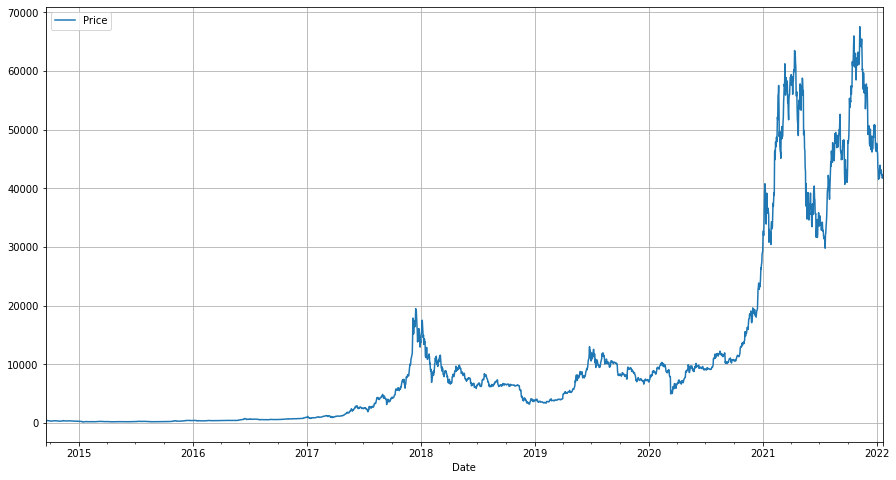

In [6]:
#Plotting Timeseries

df.plot()
plt.grid()
plt.show()

**Inference:** It's clear from the plot that there is an uptrend in the volumne of Passengers, with some seasonality. Let us perform stationarity check using visual (rolling mean & std) & statistical tests ( Dicky-Fooler's Test) to confirm the same.

---

## <center>2. Stationarize the Series

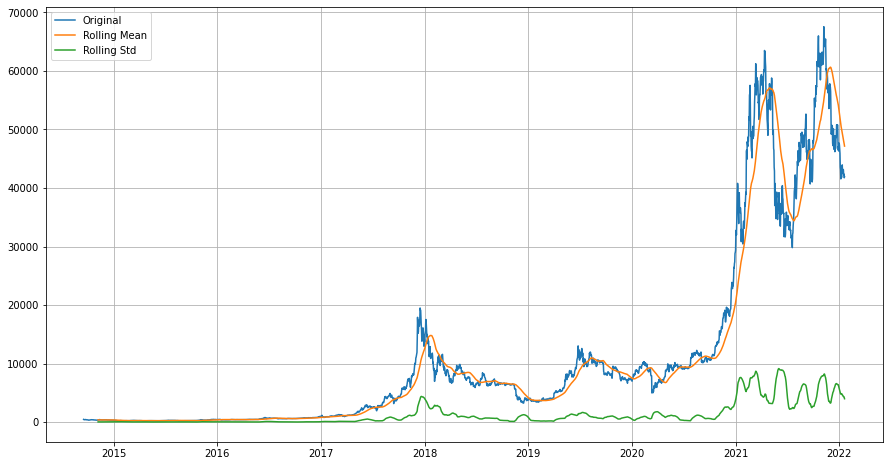

T Statistic             -1.138159
P-Value                  0.699617
#Lags Used              28.000000
#Observations Used    2654.000000
Critical value 1%       -3.432816
Critical value 5%       -2.862630
Critical value 10%      -2.567350
dtype: float64


In [7]:
#Stationary Check

def Staionarity_Check(ts):
    plt.plot(ts, label='Original')
    plt.plot(ts.rolling(window=52, center=False).mean(), label='Rolling Mean')
    plt.plot(ts.rolling(window=52, center=False).std(), label='Rolling Std')
    plt.grid()
    plt.legend()
    plt.show()
    
    adf = adfuller(ts, autolag='AIC')
    padf = pd.Series(adf[:4], index=['T Statistic','P-Value','#Lags Used','#Observations Used'])
    for k,v in adf[4].items():
        padf['Critical value {}'.format(k)]=v
    print(padf)
    
Staionarity_Check(df[variable])

**Inference:** Since the test statistic is higher than the critical value, & the rolling mean is not constant over time, therefore the null hypothesis cannot be rejected. This implies that the time-series is non-staionary!
Let us fix this by decomposing using moving average...

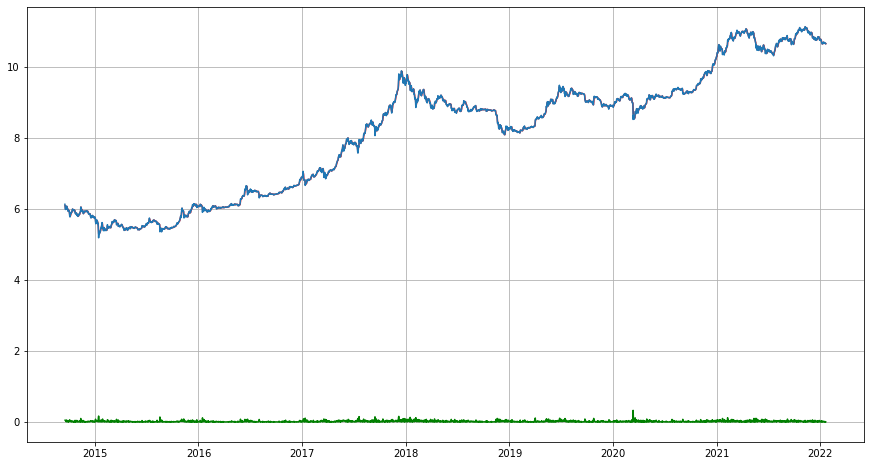

In [56]:
#Decomposing using moving average

tsl = np.log(df)
ma = tsl.rolling(window=2).mean()
ms = tsl.rolling(window=2).std()

plt.plot(ma, c='r')#, center=False)
plt.plot(ms, c='g')
plt.plot(tsl)
plt.grid()
plt.show()

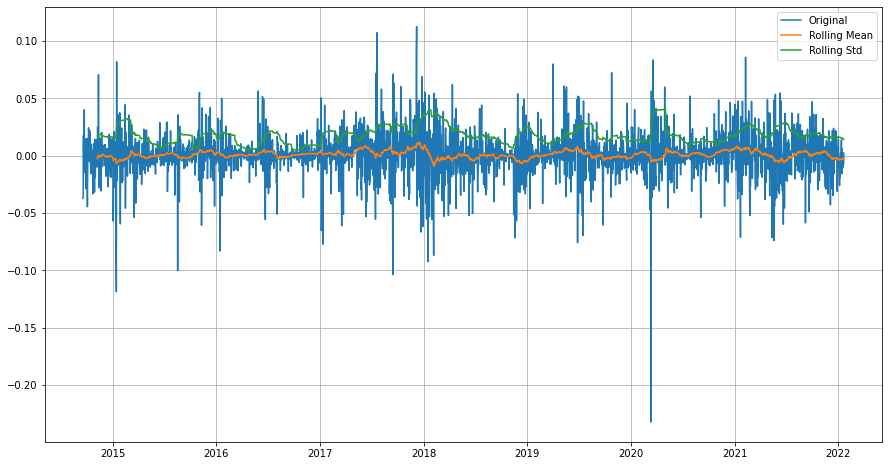

T Statistic          -1.554228e+01
P-Value               2.151715e-28
#Lags Used            9.000000e+00
#Observations Used    2.672000e+03
Critical value 1%    -3.432800e+00
Critical value 5%    -2.862622e+00
Critical value 10%   -2.567346e+00
dtype: float64


In [57]:
# Stationarity Check for Decomposed Time Series

tsl - np.log(df)
ma = tsl.rolling(window=2, center=False).mean()

tslma = tsl - ma
tslma = tslma.dropna()
Staionarity_Check(tslma)

**Inference**: Now the test staistic can be observed to be less that 5% critical value, hence the nullhypothsis can be rejected. Indicating that the time series is stationary & we can use it to create our ARIMA Model. But before that, let us find the parameters - `p` & `q` required by the model, by plotting Auto-Correlation Function & Partial Auto-Correlation Function.

---

## <center>3. Plotting ACF / PACF

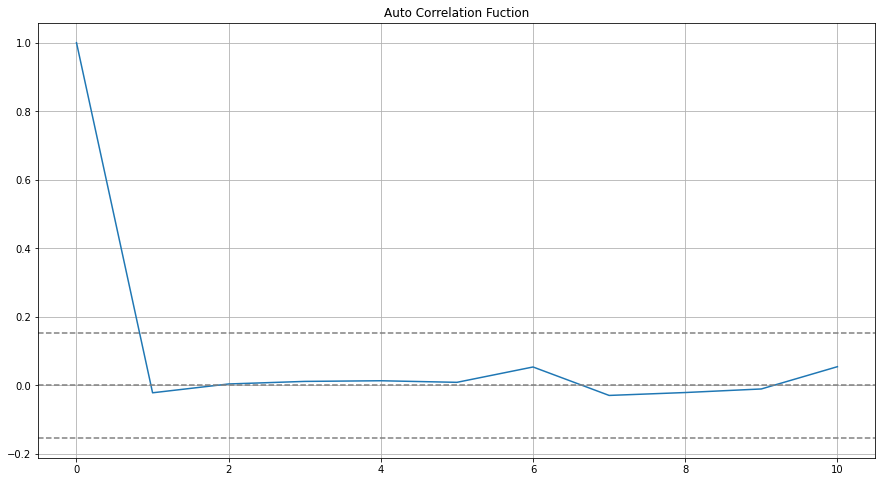

In [58]:
#Auto Correlation Fuction #q

plt.plot(np.arange(acf(tslma, nlags=10,fft=True).shape[0]),acf(tslma, nlags=10, fft=True))
plt.axhline(y=0, linestyle='--', c='gray')
plt.axhline(y=-7.96/np.sqrt(len(tslma)), linestyle='--',c='gray')
plt.axhline(y=7.96/np.sqrt(len(tslma)), linestyle='--',c='gray')

plt.title('Auto Correlation Fuction')
plt.grid()
plt.show()

**Inference:** The ACF Curve passes throught the upper confidence value when the lag value is between 5 & 6, hence the optimal value of `q` can be either 5 or 6.

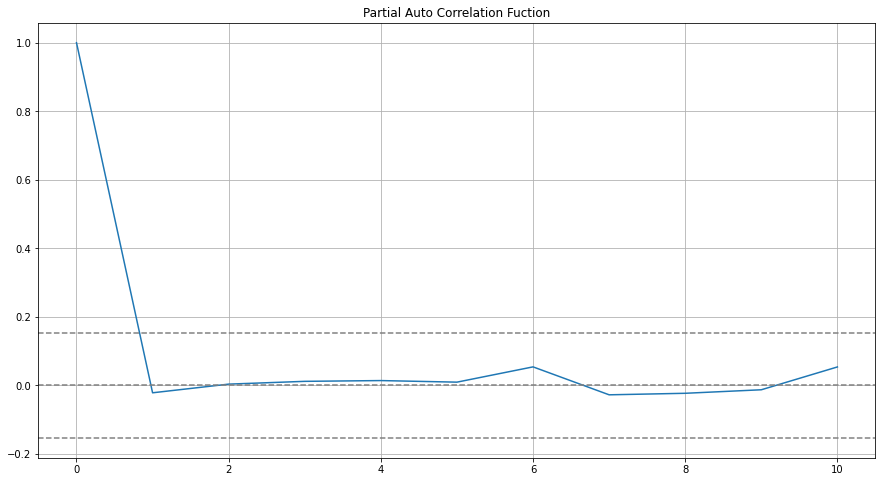

In [59]:
#Partial Auto Correlation Fuction #p

plt.plot(np.arange(pacf(tslma, nlags=10).shape[0]),pacf(tslma, nlags=10))
plt.axhline(y=0, linestyle='--', c='gray')
plt.axhline(y=-7.96/np.sqrt(len(tslma)), linestyle='--',c='gray')
plt.axhline(y=7.96/np.sqrt(len(tslma)), linestyle='--',c='gray')

plt.title('Partial Auto Correlation Fuction')
plt.grid()
plt.show()

**Inference:** The PACF Curve drops to 0 when the lag value is between 1 & 2, hence the optimal value of `p` can be either 1 or 2.

---

## <center>4. Model Building

In [65]:
#Building ARIMA Model

Arima = ARIMA(tslma, order=(1,2,2))
Ar = Arima.fit()
# plt.plot(tslma, label=['Original'])
# plt.plot(Ar.fittedvalues,c='r', label=['Forecast'])
# plt.legend()
# plt.grid()

Ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                 2682
Model:                 ARIMA(1, 2, 2)   Log Likelihood                6714.523
Date:                Fri, 04 Feb 2022   AIC                         -13421.046
Time:                        20:33:33   BIC                         -13397.472
Sample:                    09-18-2014   HQIC                        -13412.518
                         - 01-20-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0156      0.012     -1.267      0.205      -0.040       0.009
ma.L1         -1.9888      0.003   -722.445      0.000      -1.994      -1.983
ma.L2          0.9890      0.003    358.590      0.000       0.984       0.994
sigma2         0.0004   4.11e-06     92.169      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):             13135.93
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               1.47   Skew:                            -0.87
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Inference:** The Arima Model fits well on the time-series data with nearly perfect p-values. Let us now forcast the future data with the help of the trained ARIMA Model.

---

## <center>5. Forecasting

In [97]:
# Forecasting future predictions

future_dates=[df.index[-1]+ DateOffset(days=x)for x in range(0,1)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)
future_datest_df.tail()

future_df=pd.concat([df,future_datest_df])
future_df.shape

(2683, 1)

In [96]:
Ar.predict(start =2500, end = 2600, dynamic= True)

2021-07-23   -0.003560
2021-07-24   -0.003512
2021-07-25   -0.003569
2021-07-26   -0.003625
2021-07-27   -0.003680
                ...   
2021-10-27   -0.008796
2021-10-28   -0.008851
2021-10-29   -0.008907
2021-10-30   -0.008963
2021-10-31   -0.009018
Freq: D, Name: predicted_mean, Length: 101, dtype: float64

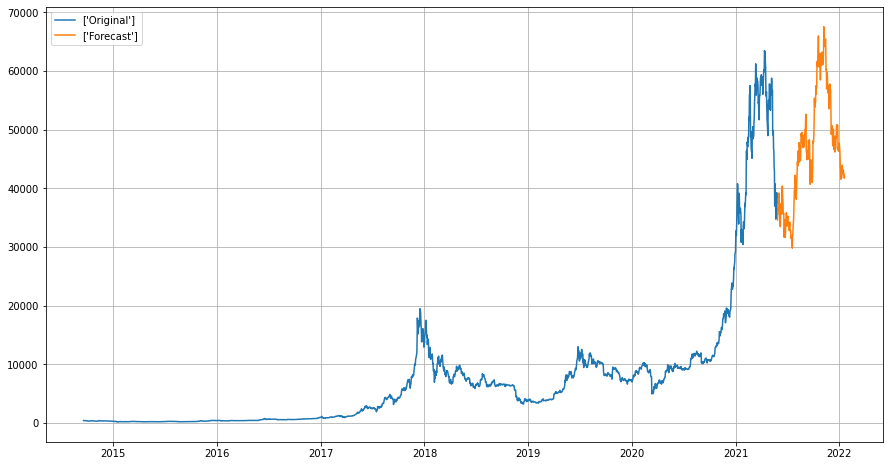

In [99]:
# Forecasting future predictions

future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)
future_datest_df.tail()

future_df=pd.concat([df,future_datest_df])

future_df['Price'] += Ar.predict(start =0, end = 2683, dynamic= True)

plt.plot(future_df[variable][:-260], label=['Original'])
plt.plot((future_df['Price'][-260:]+(1.08*ma.mean()[0])), label=['Forecast'])
plt.grid()
plt.legend()
plt.show()

**Inference:**<br>
The model's forecast seems to be precise as it captures most of the sesonality & possible trends in the time-series data.


---

## <center> Project Outcomes & Conclusions

### Here are some of the key outcomes of the project:
- The Bitcoin Price Time-Series Dataset was quiet small, with just 2683 samples.
- It was clear from the visuals that the time-series dataset had an upward trend & some seasonality.
- The same was confirmed with help of visual (rolling mean & std) & statistical (Dicky-Fuller Test) stionarity checks.
- The time-series was subject to Decomposition in order to stationarize the outputs.
- Futher ACF & PACF curves were plotted to extract the values of p & q, as it is required for the ARIMA Model.
- The Forecasting Model was then built with the time-series data, by feeding the optimal p,q,d values.
- Finally, the model was used to forecast the time-series of the bitcoin prices, into the future.

In [11]:
#<<<------------------------------------- THE END ----------------------------------------------->>>